<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from skimage.transform import resize
import nibabel as nib
import copy
from glob import glob


C:\Users\wogur\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dataset_dir = '../dataset/ct_train_test/ct_train/'
pair_list = glob('{}/*.nii/*.nii'.format(dataset_dir))
print(len(pair_list))

40


In [3]:
rename_map = [0, 205, 420, 500, 550, 600, 820, 850]

In [4]:
def load_data_pairs(pair_list, resize_r, rename_map):
    """load all volume pairs"""
    img_clec = []
    label_clec = []

    # rename_map = [0, 205, 420, 500, 550, 600, 820, 850]
    for k in range(0, len(pair_list), 2):
        img_path = pair_list[k]
        lab_path = pair_list[k+1]
        img_data = nib.load(img_path).get_data().copy()
        lab_data = nib.load(lab_path).get_data().copy()

        ###preprocessing
        # resize
        resize_dim = (np.array(img_data.shape) * resize_r).astype('int')
        img_data = resize(img_data, resize_dim, order=1, preserve_range=True)
        lab_data = resize(lab_data, resize_dim, order=0, preserve_range=True)
        lab_r_data = np.zeros(lab_data.shape, dtype='int32')

        # rename labels
        for i in range(len(rename_map)):
            lab_r_data[lab_data == rename_map[i]] = i

        # for s in range(img_data.shape[2]):
        #     cv2.imshow('img', np.concatenate(((img_data[:,:,s]).astype('uint8'), (lab_r_data[:,:,s]*30).astype('uint8')), axis=1))
        #     cv2.waitKey(20)

        img_clec.append(img_data)
        label_clec.append(lab_r_data)

    return img_clec, label_clec

In [5]:
img, label = load_data_pairs(pair_list[:2], 0.6, rename_map)

C:\Users\wogur\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [7]:
print(img[0].shape)
print(label[0].shape)

(307, 307, 217)
(307, 307, 217)


---

In [11]:
def fit_cube_param(vol_dim, cube_size, ita):
    dim = np.asarray(vol_dim)
    # cube number and overlap along 3 dimensions
    fold = dim / cube_size + ita
    ovlap = np.ceil(np.true_divide((fold * cube_size - dim), (fold - 1)))
    ovlap = ovlap.astype('int')

    fold = np.ceil(np.true_divide((dim + (fold - 1)*ovlap), cube_size))
    fold = fold.astype('int')

    return fold, ovlap

In [45]:
# decompose volume into list of cubes
def decompose_vol2cube(vol_data, batch_size, cube_size, n_chn, ita):
    cube_list = []
    # get parameters for decompose
    fold, ovlap = fit_cube_param(vol_data.shape, cube_size, ita)
    dim = np.asarray(vol_data.shape)
    # decompose
    for R in range(0, fold[0]):
        r_s = R*cube_size - R*ovlap[0]
        r_e = r_s + cube_size
        if r_e >= dim[0]:
            r_s = dim[0] - cube_size
            r_e = r_s + cube_size
        for C in range(0, fold[1]):
            c_s = C*cube_size - C*ovlap[1]
            c_e = c_s + cube_size
            if c_e >= dim[1]:
                c_s = dim[1] - cube_size
                c_e = c_s + cube_size
            for H in range(0, fold[2]):
                h_s = H*cube_size - H*ovlap[2]
                h_e = h_s + cube_size
                if h_e >= dim[2]:
                    h_s = dim[2] - cube_size
                    h_e = h_s + cube_size
                # partition multiple channels
                cube_temp = vol_data[r_s:r_e, c_s:c_e, h_s:h_e]
                cube_batch = np.zeros([batch_size, cube_size, cube_size, cube_size, n_chn]).astype('float32')
                cube_batch[0, :, :, :, 0] = copy.deepcopy(cube_temp)
                # save
                cube_list.append(cube_batch)

    return cube_list

In [69]:
def compose_label_cube2vol(cube_list, vol_dim, cube_size, ita, class_n):
    # get parameters for compose
    fold, ovlap = fit_cube_param(vol_dim, cube_size, ita)
    # create label volume for all classes
    label_classes_mat = (np.zeros([vol_dim[0], vol_dim[1], vol_dim[2], class_n])).astype('int32')
    idx_classes_mat = (np.zeros([cube_size, cube_size, cube_size, class_n])).astype('int32')

    p_count = 0
    for R in range(0, fold[0]):
        r_s = R*cube_size - R*ovlap[0]
        r_e = r_s + cube_size
        if r_e >= vol_dim[0]:
            r_s = vol_dim[0] - cube_size
            r_e = r_s + cube_size
        for C in range(0, fold[1]):
            c_s = C*cube_size - C*ovlap[1]
            c_e = c_s + cube_size
            if c_e >= vol_dim[1]:
                c_s = vol_dim[1] - cube_size
                c_e = c_s + cube_size
            for H in range(0, fold[2]):
                h_s = H*cube_size - H*ovlap[2]
                h_e = h_s + cube_size
                if h_e >= vol_dim[2]:
                    h_s = vol_dim[2] - cube_size
                    h_e = h_s + cube_size
                # histogram for voting
                for k in range(class_n):
                    idx_classes_mat[:, :, :, k] = (cube_list[p_count].reshape((96,96,96)) == k)
                # accumulation
                label_classes_mat[r_s:r_e, c_s:c_e, h_s:h_e, :] = label_classes_mat[r_s:r_e, c_s:c_e, h_s:h_e, :] + idx_classes_mat

                p_count += 1
    # print 'label mat unique:'
    # print np.unique(label_mat)

    compose_vol = np.argmax(label_classes_mat, axis=3)
    # print np.unique(label_mat)

    return compose_vol

---

In [2]:
pred = nib.load('../predict_image/UNET_3D_21_96_7/UNET_3D_21_96_7_0.nii')
pred_image = pred.get_data().copy()
pred_image.shape

(512, 512, 224)

In [3]:
import matplotlib.pyplot as plt

In [7]:
np.unique(pred_image)

array([0], dtype=int16)

In [6]:
pred = nib.load('../predict_image/UNET_3D_22/UNET_3D_22_0.nii')
pred_affine = pred.affine
pred_image = pred.get_data().copy()
pred_image.shape

(512, 512, 224)

In [7]:
np.unique(pred_image)

array([  0, 205, 420, 500, 550, 600, 820, 850], dtype=int16)

In [8]:
rename_map = [0, 205, 420, 500, 550, 600, 820, 850]
for i in range(len(rename_map)):
    pred_image[pred_image==rename_map[i]] = i

In [9]:
np.unique(pred_image)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int16)

In [10]:
pred_image.shape

(512, 512, 224)

In [11]:
# pred_image = pred_image.astype('float32')

In [12]:
pred_image.dtype

dtype('<i2')

In [13]:
np.unique(pred_image)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int16)

In [14]:
pred_save = nib.Nifti1Image(pred_image, affine=pred_affine)
nib.save(pred_save, '../predict_image/UNET_3D_22/UNET_3D_22_0(color).nii')

In [15]:
import matplotlib.pyplot as plt

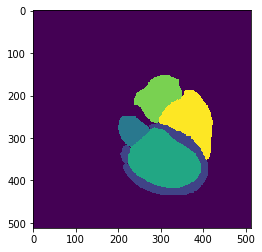

In [16]:
plt.imshow(pred_image[:,:,112])